#  Overview

Write it down here:

# Research Question

Does the amount of space dedicated to parks correlate to the average income in an area?

# Background & Prior Work

According to Coth Jones, and communications manager at the National Recreation and Parks Association, parks are a effective way to improve the standard of living. Jones reported that almost unanimous agreement in local government officials belief that the parks system has been effective to benefit the community (99% agree). He argues the parks system brings in wealth in the community tot he tune of almost 32 bllion extra dollars in GDP. To add, the City of Arlington took a survey of its residents and they said that 92% of them were satisfied with the athletics system and the value of homes that were located near parks or natural areas had increased the value of their land. They increased by over 10,000 dollars for homes located near natural areas and by over 1000 dollars for homes within 1,500 ft near an urban park. They found data from a Nebraska study cited in the Active Living Research that every dollar spent on trials directly resulted in 3 dollars saved on medical expenses. "Many cities feel they must choose between economic growth and open space protection. In most cases, however, no such choice is necessary" (City of Arlington).
    - 1) The City of Arlington (https://www.como.gov/parksandrec/wp-content/uploads/sites/25/2017/09/eco_impact_parks_naturallyfunmag_arlington.pdf),
    - 2)Cort Jones, Communications Manager at National Recreation and Parks Association
    (https://icma.org/blog-posts/economic-impact-parks-and-recreation#:~:text=Parks%2C%20open%20space%2C%20and%20recreation,can%20ripple%20throughout%20the%20economy.)"

# Hypothesis

I believe that wages will be positively correlated with the amount of park space in an area because access to a place to exercise and spend time outside normally contribute to increased happiness, which will result in wealthier people moving near parks

# Setup

In [35]:
!pip install geopandas
!pip install pandas

In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17, 5)
plt.rcParams.update({'font.size': 16})
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

import shapely.geometry as shape
from shapely.geometry import Polygon
from shapely.geometry import MultiPolygon

import json

import sklearn.neighbors as skn
import sklearn.metrics as skm

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 10

#improve resolution
#comment this line if erroring on your machine/screen
%config InlineBackend.figure_format ='retina'

# Datasets

To complete this project, a couple of datasets are necessary:

The first dataset I'll use will be for analyzing incomes in particular zip codes in San Diego. I will put the averages on top of a map of San Diego county to accurate predict the income based on locations. Based on the code below, you can see I have 11300 observations in the dataframe. This is an outside source from SANDAG data estimates.

Link: https://datasurfer.sandag.org/dataoverview

In [6]:
df_zip_incomes = pd.read_csv('Income-Table 1.csv')
print(df_zip_incomes.head())
print(df_zip_incomes.count())

     ZIP  YEAR  ORDINAL        INCOME GROUP  HOUSEHOLDS
0  91901  2010        1   Less than $15,000         469
1  91901  2010        2  $15,000 to $29,999         794
2  91901  2010        3  $30,000 to $44,999         749
3  91901  2010        4  $45,000 to $59,999         541
4  91901  2010        5  $60,000 to $74,999         603
ZIP             11300
YEAR            11300
ORDINAL         11300
INCOME GROUP    11300
HOUSEHOLDS      11300
dtype: int64


The next dataset I want to use is a geojson so I can see a map of the zip codes I am working with. I will put the income averages on top of this map. This is another outside dataset not given to us, and I got it from the city.

Link: https://data.sandiegocounty.gov/Maps-and-Geographical-Resources/Zip-Codes/vsuf-uefy

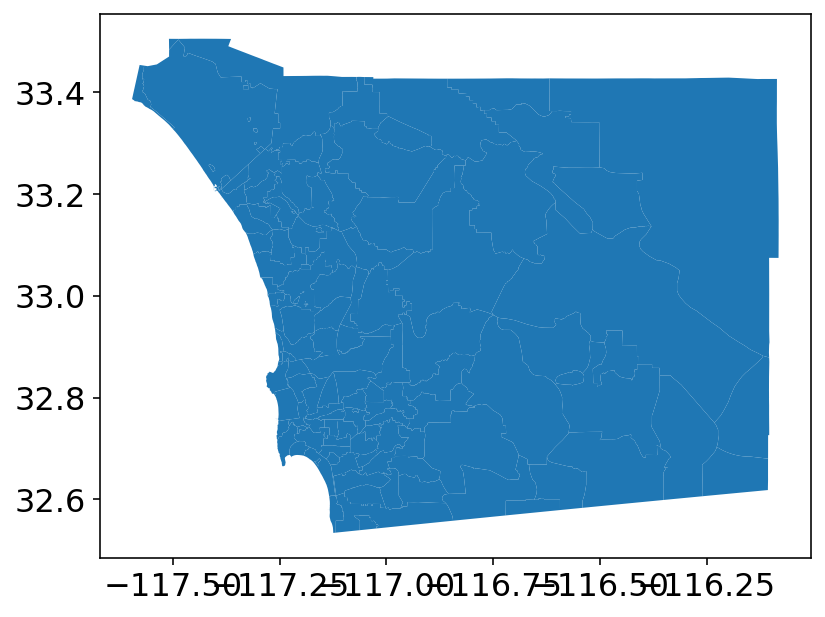

In [7]:
Zip_codes = gpd.read_file('Zip Codes.geojson')
#The next dataset is to get addresses of crimes that were committed in San Diego county this year
Zip_codes.plot();

In [8]:
Zip_codes

community     shape_star     shape_stle    zip  \
0          Alpine  4149939944.16  326045.262676  91901   
1          Bonita  273909416.836  113257.374615  91902   
2       Boulevard  2735681408.51  241725.552214  91905   
3           Campo  3066759065.62  287410.325075  91906   
4     Chula Vista  403437442.009  112587.791814  91910   
..            ...            ...            ...    ...   
117    San Ysidro  110367415.137  52066.7970992  92173   
118     San Diego   9608104.6377  17525.5972041  92182   
119      Ocotillo  1978752344.38  194340.478076  92259   
120       Aguanga  1389176969.58  206176.033344  92536   
121  San Clemente  207151719.759   125487.98907  92672   

                                              geometry  
0    MULTIPOLYGON (((-116.74539 32.96063, -116.7408...  
1    MULTIPOLYGON (((-116.97172 32.70838, -116.9712...  
2    MULTIPOLYGON (((-116.23165 32.75083, -116.2280...  
3    MULTIPOLYGON (((-116.35677 32.70460, -116.3572...  
4    MULTIPOLYGON (((-117.06354 32.65011, -117.0634...  
..                                                 ...  
117  MULTIPOLYGON (((-117.06510 32.56911, -117.0639...  
118  MULTIPOLYGON (((-117.07351 32.77926, -117.0704...  
119  MULTIPOLYGON (((-116.10322 32.87887, -116.1031...  
120  MULTIPOLYGON (((-116.69356 33.42741, -116.6853...  
121  MULTIPOLYGON (((-117.57210 33.45299, -117.5695...  

[122 rows x 5 columns]

This dataset is a map of the locations of all the parks in San Diego County. This map will be a great visualization of where parks are located and will help analyze the percentage of a zip code's land dedicated to park land.

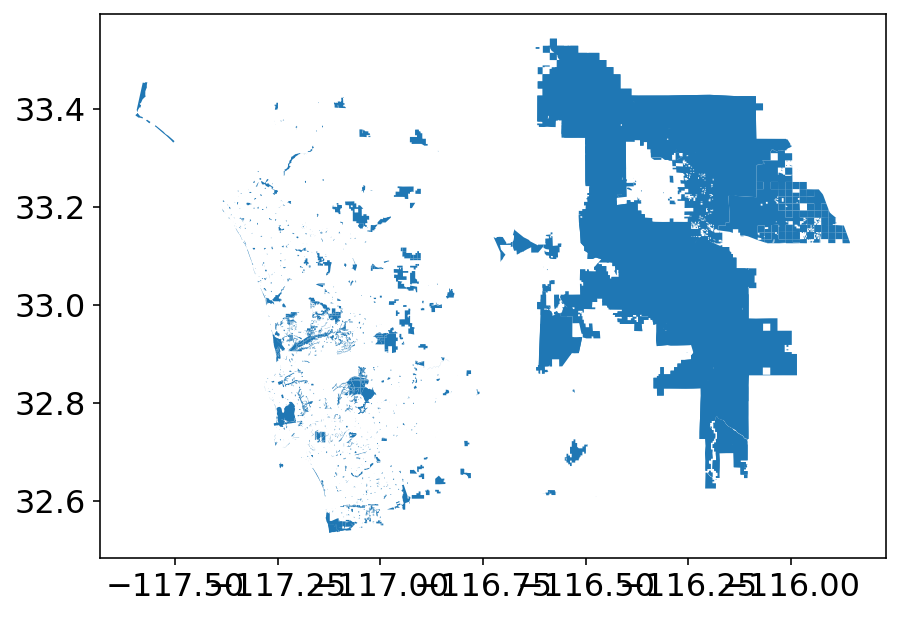

In [9]:
Parks = gpd.read_file('parks_datasd.geojson')
Parks.plot();

In [10]:
Parks

objectid                           name  \
0            1              South Carlsbad SB   
1            2                Torrey Pines SB   
2            3                    Ruocco Park   
3            4               Tuna Harbor Park   
4            5        San Diego Bayfront Park   
...        ...                            ...   
2764      2765        San Luis Rey River Park   
2765      2766  Horse Creek Ridge Sports Park   
2766      2767                                  
2767      2768   Harmony Grove Community Park   
2768      2769  Harmony Grove Equestrian Park   

                                       alias   gis_acres   park_type  \
0                 South Carlsbad State Beach  115.895878       State   
1                   Torrey Pines State Beach   67.294309       State   
2                                Ruocco Park    3.312526       Local   
3                           Tuna Harbor Park    0.639035       Local   
4                    San Diego Bayfront Park    3.669272       Local   
...                                      ...         ...         ...   
2764                 San Luis Rey River Park  712.262117  Open Space   
2765           Horse Creek Ridge Sports Park    8.398529       Local   
2766  Harmony Grove Village 4th of July Park    2.510408       Local   
2767    Harmony Grove Village Community Park    3.575260       Local   
2768   Harmony Grove Village Equestrian Park    3.647259       Local   

                                          location        owner  \
0                                                   State Parks   
1                                                   State Parks   
2             585 Harbor Ln, San Diego. California        SDUPD   
3       700 North Harbor Dr, San Diego. California        SDUPD   
4        One Park Boulevard, San Diego. California        SDUPD   
...                                            ...          ...   
2764         5521 W. Lilac Road, Bonsall, CA 92003   County DPR   
2765    240 Gold Palomino Way, Fallbrook CA, 92028   County DPR   
2766     2815 STARRY NIGHT DR, Escondido, CA 92029   County DPR   
2767  2982 Harmony Grove Road, Escondido, CA 92029   County DPR   
2768  2850 Harmony Grove Road, Escondido, CA 92029   County DPR   

                                               geometry  
0     MULTIPOLYGON (((-117.31431 33.09015, -117.3142...  
1     POLYGON ((-117.26147 32.93883, -117.26181 32.9...  
2     POLYGON ((-117.17298 32.71167, -117.17303 32.7...  
3     POLYGON ((-117.17260 32.71160, -117.17268 32.7...  
4     MULTIPOLYGON (((-117.16074 32.70407, -117.1594...  
...                                                 ...  
2764  MULTIPOLYGON (((-117.17632 33.31105, -117.1766...  
2765  POLYGON ((-117.15413 33.35376, -117.15413 33.3...  
2766  POLYGON ((-117.13226 33.10238, -117.13225 33.1...  
2767  POLYGON ((-117.13391 33.09869, -117.13376 33.0...  
2768  POLYGON ((-117.13258 33.09964, -117.13258 33.0...  

[2769 rows x 8 columns]

# Data Cleaning

There is a lot of data cleaning that has to be done, so let's do it step by step and make sure we do not get confused

In [11]:
df_zip_incomes

ZIP  YEAR  ORDINAL          INCOME GROUP  HOUSEHOLDS
0      91901  2010        1     Less than $15,000         469
1      91901  2010        2    $15,000 to $29,999         794
2      91901  2010        3    $30,000 to $44,999         749
3      91901  2010        4    $45,000 to $59,999         541
4      91901  2010        5    $60,000 to $74,999         603
...      ...   ...      ...                   ...         ...
11295  92672  2019        6    $75,000 to $99,999         117
11296  92672  2019        7  $100,000 to $124,999          91
11297  92672  2019        8  $125,000 to $149,999          23
11298  92672  2019        9  $150,000 to $199,999          18
11299  92672  2019       10      $200,000 or more           5

[11300 rows x 5 columns]

This looks great on the surface, but it includes data from the early 2010s. To increase the accuracy of this dataset for this year, I am going to cut down the dataset to only include data from the past 5 years (2015-Now). I will also see if there are any missing values

In [12]:
df_zip_incomes = df_zip_incomes[df_zip_incomes['YEAR'] >= 2015]
print(df_zip_incomes)
print(df_zip_incomes[df_zip_incomes.isnull().any(axis=1)])

         ZIP  YEAR  ORDINAL          INCOME GROUP  HOUSEHOLDS
50     91901  2015        1     Less than $15,000         495
51     91901  2015        2    $15,000 to $29,999         789
52     91901  2015        3    $30,000 to $44,999         729
53     91901  2015        4    $45,000 to $59,999         503
54     91901  2015        5    $60,000 to $74,999         539
...      ...   ...      ...                   ...         ...
11295  92672  2019        6    $75,000 to $99,999         117
11296  92672  2019        7  $100,000 to $124,999          91
11297  92672  2019        8  $125,000 to $149,999          23
11298  92672  2019        9  $150,000 to $199,999          18
11299  92672  2019       10      $200,000 or more           5

[5650 rows x 5 columns]
Empty DataFrame
Columns: [ZIP, YEAR, ORDINAL, INCOME GROUP, HOUSEHOLDS]
Index: []


This cuts the dataset in half, and there are no missing values. This is where some subjection occurs as well. SANDAG organizes their data in a way that gives us a range of values to visualize easier. This will force me to make a few decisions.

I am going to first take the average of the ranges to get one number. I will assume that the data between values like 15,000 - 29,999 are normally distributed to get a value of 22,500. I will also combine all the mean values per year and make them seem as if they were collected in the same year. This will give the appearance of one zip code having one average value. Lastly, I am going to assume that 200,000 or more is going to be 250,000. Also, the mininum wage in San Diego is large enough to make more than 15,000 dollars a year, so I'll make Less than 15,000 equal to 0.

In [13]:
def standardize_income(string):
    
    string = string.lower()
    string = string.strip()

    if "less than $15,000" in string:
        output = '0'
    elif "$15,000 to $29,999" in string:
        output = '22500'
    elif "$30,000 to $44,999" in string:
        output = '37500'
    elif "$45,000 to $59,999" in string:
        output = '52500'
    elif "$60,000 to $74,999" in string:
        output = '67500'
    elif "$75,000 to $99,999" in string:
        output = '87500'
    elif "$100,000 to $124,999" in string:
        output = '112500'
    elif "$125,000 to $149,999" in string:
        output = '137500'
    elif "$150,000 to $199,999" in string:
        output = '175000'
    elif "$200,000 or more" in string:
        output = '250000'
    else:
        output = np.nan
        
    return output    

In [14]:
df_zip_incomes['INCOME GROUP'] = df_zip_incomes['INCOME GROUP'].apply(standardize_income)
df_zip_incomes['INCOME GROUP'] = df_zip_incomes['INCOME GROUP'].astype(np.int64)

In [15]:
#Make a new column with total revenue from households in income bracket
df_zip_incomes['TOTAL REVENUE'] = df_zip_incomes['INCOME GROUP'] * df_zip_incomes['HOUSEHOLDS']

In [16]:
#Make the list of Zip Codes into a list of strings
df_zip_incomes['ZIP'].apply(str)

50       91901
51       91901
52       91901
53       91901
54       91901
         ...  
11295    92672
11296    92672
11297    92672
11298    92672
11299    92672
Name: ZIP, Length: 5650, dtype: object

In [17]:
# This outlier was due to one household, so it is better to remove this household
df_zip_incomes['HOUSEHOLDS'] = df_zip_incomes['HOUSEHOLDS'].replace([1,0])

In [18]:
#Find the total sum per ZIP Code and make a new dataframe
df1 = df_zip_incomes.groupby('ZIP', as_index = False)['TOTAL REVENUE'].sum()

In [19]:
# Find the number of households per ZIP Code
df2 = df_zip_incomes.groupby('ZIP', as_index = False)['HOUSEHOLDS'].sum()

Now let's make our Dataset that we are going to use for our analysis!

In [20]:
df_zip_average = df1.join(df2.set_index('ZIP'), on = 'ZIP')
df_zip_average

ZIP  TOTAL REVENUE  HOUSEHOLDS
0    91901     2883990000       31469
1    91902     2865665000       28929
2    91905      230700000        3474
3    91906      406727500        6323
4    91910     9057545000      132564
..     ...            ...         ...
108  92173     1885725000       38123
109  92182              0        8750
110  92259              0        8750
111  92536       52975000         950
112  92672      304805000        6089

[113 rows x 3 columns]

In [21]:
#Now make a column for the average household income
df_zip_average['Average_income'] = df_zip_average['TOTAL REVENUE'] / df_zip_average['HOUSEHOLDS']

In [22]:
#Now that you know how you got the average household income, drop the 2 columns you don't need anymore and rename the 'ZIP' column 'zip' to merge later on
df_zip_average = df_zip_average.drop(['TOTAL REVENUE', 'HOUSEHOLDS'], axis = 1)
df_zip_average = df_zip_average.rename(str.lower, axis = 'columns')
df_zip_average['average_income'].apply(str)
df_zip_average

zip  average_income
0    91901    91645.428835
1    91902    99058.557157
2    91905    66407.599309
3    91906    64325.083030
4    91910    68325.827525
..     ...             ...
108  92173    49464.234189
109  92182        0.000000
110  92259        0.000000
111  92536    55763.157895
112  92672    50058.301856

[113 rows x 2 columns]

In [23]:
#Find the null values
df_zip_average[df_zip_average.isnull().any(axis=1)]

Empty DataFrame
Columns: [zip, average_income]
Index: []

After plugging in the zip codes above into Google Maps, it make sense that we did not get any values for them. All of this zip codes are for Hospitals, Schools, or Naval Bases, so we do not need them in our analysis.

This next line of code will open up all the features in the GeoJson to help us navigate it:

In [24]:
geo_objects = json.load(open("Zip Codes.geojson"))
geo_objects

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {'community': 'Alpine',
    'shape_star': '4149939944.16',
    'shape_stle': '326045.262676',
    'zip': '91901'},
   'geometry': {'type': 'MultiPolygon',
    'coordinates': [[[[-116.74539162745315, 32.960631292711774],
       [-116.74084600248574, 32.958532334213096],
       [-116.73884121593645, 32.94995315144447],
       [-116.73880383949034, 32.94979318916339],
       [-116.73880507393332, 32.94972206855355],
       [-116.73881766523962, 32.94905586707469],
       [-116.73886403105033, 32.94905506814097],
       [-116.74014100898495, 32.94903310778404],
       [-116.74028257789018, 32.94899166363109],
       [-116.74020856909769, 32.948288014284984],
       [-116.73967201906036, 32.947644945097075],
       [-116.7395439854945, 32.94631177419916],
       [-116.73952961563737, 32.946072714532185],
       [-116.73951035651812, 32.9458336797129],
       [-116.73948621004362, 32.94559500504054],
       [-11

Now, let's add the averages as a part of the GeoJson:

In [25]:
for geos in geo_objects['features']:
    this_zip = int(geos['properties']['zip'])
    this_ave = float(df_zip_average['average_income'][df_zip_average['zip'] == this_zip].values[0])
    geos['properties']['ave'] = this_ave

Because of the method we used above, we must turn the dictionary that we made into a file that we can plot on. To do this, we should make a GeoPandasDataFrame:

In [26]:
from shapely.geometry import shape
geom = [shape(i['geometry']) for i in geo_objects['features']]
zips = [i['properties']['zip'] for i in geo_objects['features']]
aves = [i['properties']['ave'] for i in geo_objects['features']]
geo_object = gpd.GeoDataFrame({'geometry' : geom, 'zips': zips, 'averages': aves})
geo_object

geometry   zips      averages
0    MULTIPOLYGON (((-116.74539 32.96063, -116.7408...  91901  91645.428835
1    MULTIPOLYGON (((-116.97172 32.70838, -116.9712...  91902  99058.557157
2    MULTIPOLYGON (((-116.23165 32.75083, -116.2280...  91905  66407.599309
3    MULTIPOLYGON (((-116.35677 32.70460, -116.3572...  91906  64325.083030
4    MULTIPOLYGON (((-117.06354 32.65011, -117.0634...  91910  68325.827525
..                                                 ...    ...           ...
117  MULTIPOLYGON (((-117.06510 32.56911, -117.0639...  92173  49464.234189
118  MULTIPOLYGON (((-117.07351 32.77926, -117.0704...  92182      0.000000
119  MULTIPOLYGON (((-116.10322 32.87887, -116.1031...  92259      0.000000
120  MULTIPOLYGON (((-116.69356 33.42741, -116.6853...  92536  55763.157895
121  MULTIPOLYGON (((-117.57210 33.45299, -117.5695...  92672  50058.301856

[122 rows x 3 columns]

# Data Visualization

Now lets see what our maps look like.

Now we can plot the result and see the distribution of wealth in San Diego County by zip code:

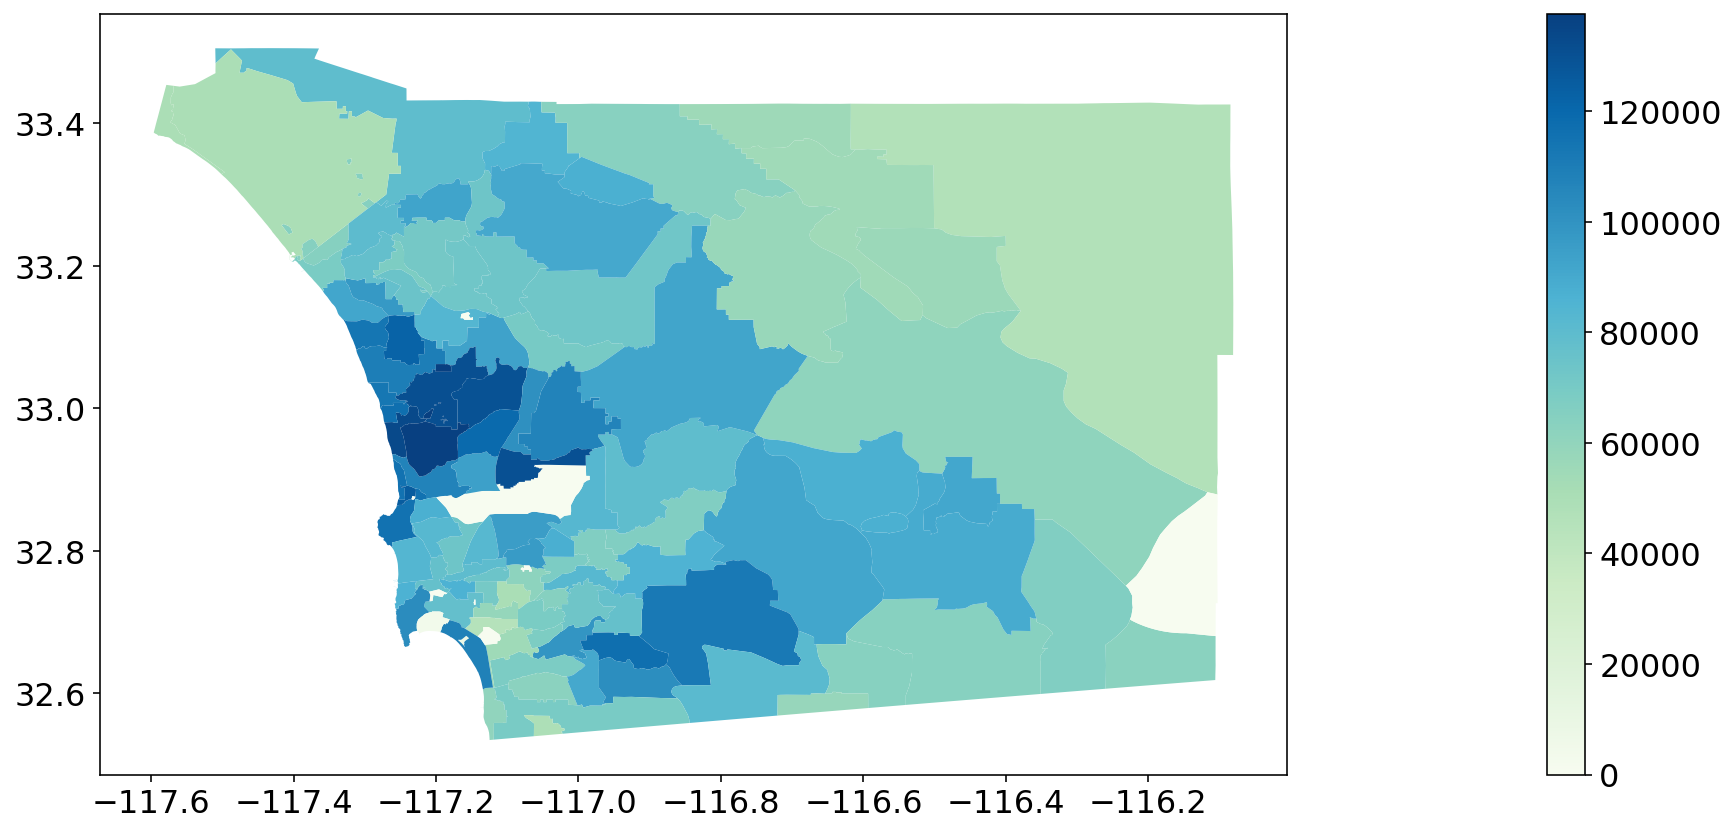

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(17, 7))
divider = make_axes_locatable(ax)
geo_object.plot(column = 'averages', cmap='GnBu' ,ax=ax, legend=True);

Next, let's see the distribution of the average incomes across the different zip codes:

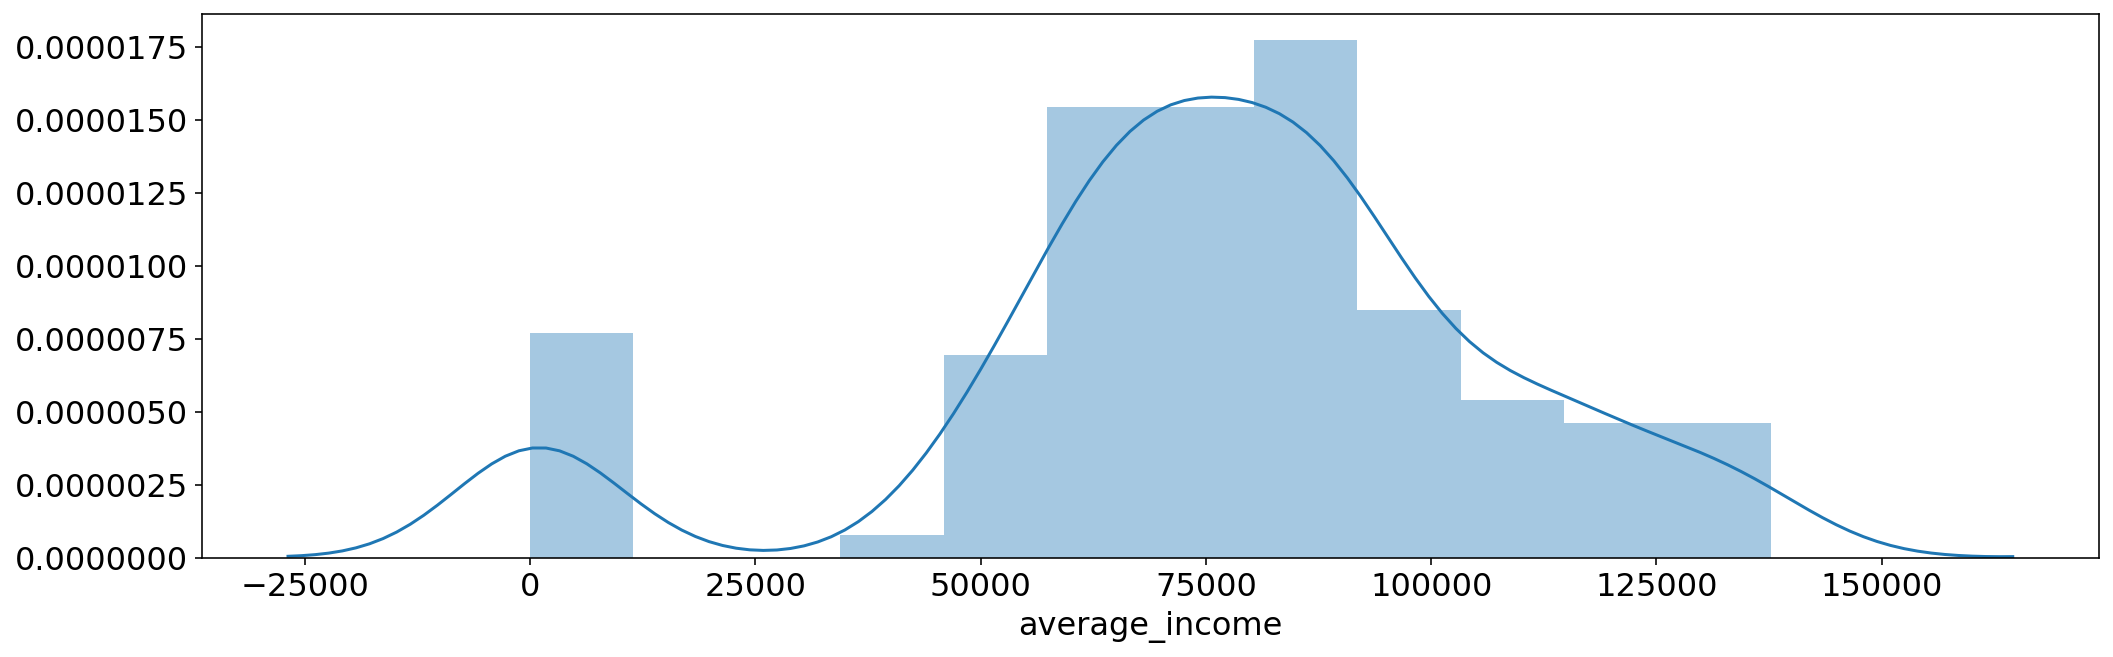

In [28]:
sns.distplot(df_zip_average['average_income']);

I dont like the way it calculates the 0 household zip codes, so im going to get rid of the 0's in the plot and recreate the displot

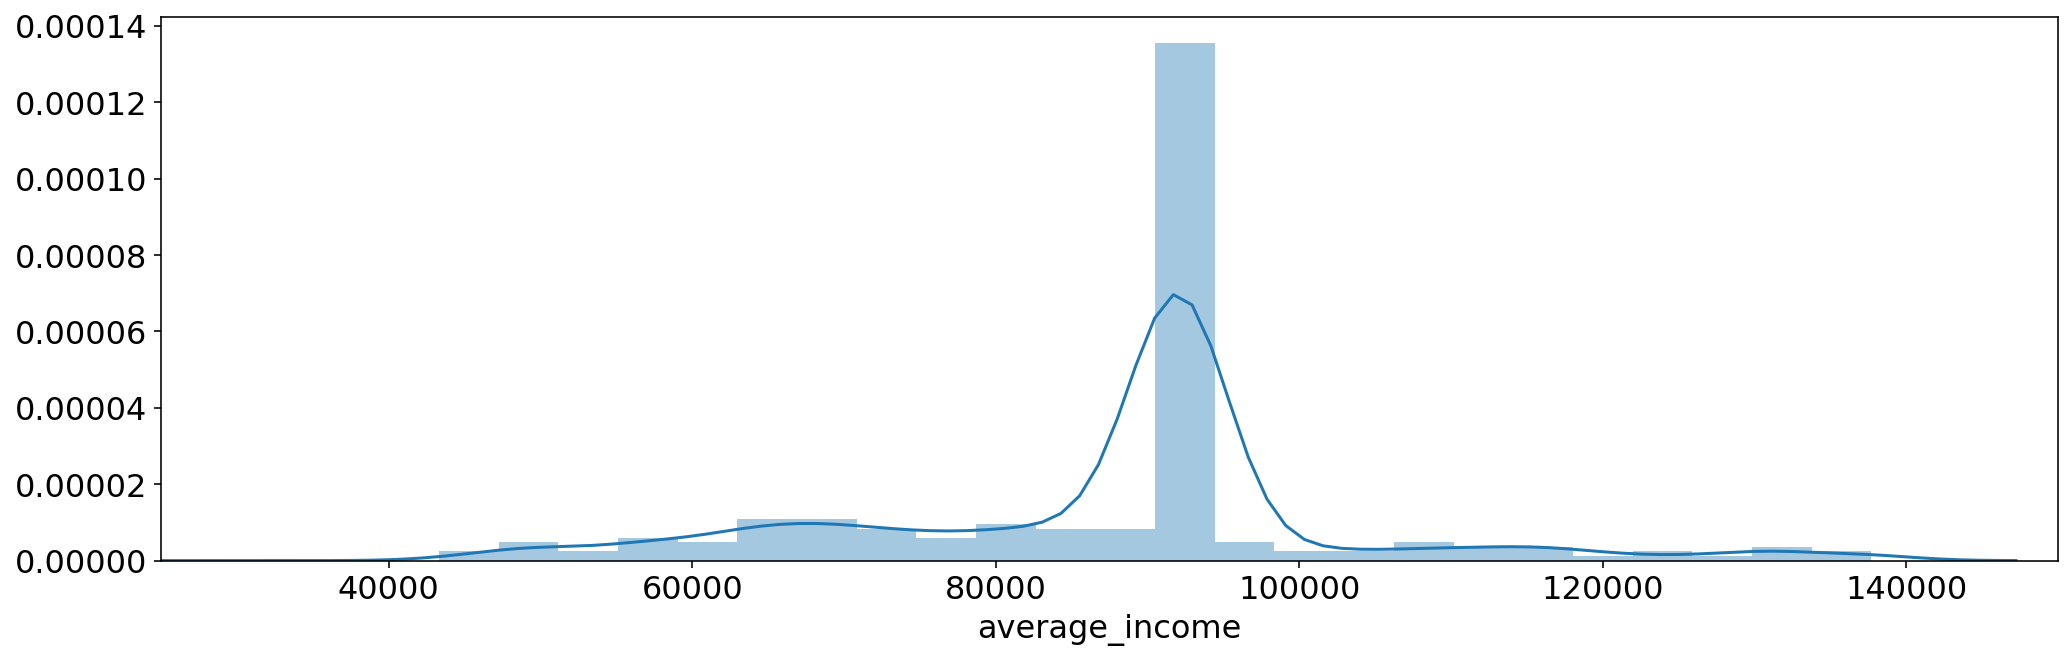

In [29]:
fig, ax = plt.subplots()
sns.distplot(df_zip_average[df_zip_average['average_income'] > 0], axlabel = 'average_income')
ax.set_xlim(25000,150000)
plt.show()

Interesting, most of the values that we observe are around 90,000 dollars!

Now lets combine the parks data and the zip code plot that we made:

In [ ]:
map_data = gpd.sjoin(geo_object, Parks, how='inner', op='intersects')

# Data Analysis & Results

In [30]:
gpd.show_versions()

Failed `CDLL(/Library/Frameworks/GEOS.framework/Versions/Current/GEOS)`
Failed `CDLL(/opt/local/lib/libgeos_c.dylib)`
Failed `CDLL(/usr/local/lib/libgeos_c.dylib)`



SYSTEM INFO
-----------
python     : 3.7.6 (default, Jan  8 2020, 13:42:34)  [Clang 4.0.1 (tags/RELEASE_401/final)]
executable : /opt/anaconda3/bin/python
machine    : Darwin-20.1.0-x86_64-i386-64bit

GEOS, GDAL, PROJ INFO
---------------------
GEOS       : None
GEOS lib   : None
GDAL       : 2.4.4
GDAL data dir: /Users/markjosephsinclair/.local/lib/python3.7/site-packages/fiona/gdal_data
PROJ       : 7.2.0
PROJ data dir: /Users/markjosephsinclair/.local/lib/python3.7/site-packages/pyproj/proj_dir/share/proj

PYTHON DEPENDENCIES
-------------------
geopandas  : 0.8.1
pandas     : 1.0.1
fiona      : 1.8.18
numpy      : 1.18.1
shapely    : 1.7.1
rtree      : 0.9.3
pyproj     : 3.0.0.post1
matplotlib : 3.1.3
mapclassify: None
geopy      : 2.0.0
psycopg2   : None
geoalchemy2: None
pyarrow    : None


# Ethics & Privacy

# Conclusion & Dicussion